In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error, confusion_matrix, f1_score
import xgboost as xgb

from utils import SOSEncoder, TargetEncoder

import warnings
warnings.filterwarnings('ignore')

## Configuration

In [45]:
DIR = 'D:\\PPrograms\\Python\\Kaggle\\Predicting Loan Pay\\'
TARGET = 'loan_paid_back'
SEED = 42

In [46]:
train = pd.read_csv(os.path.join(DIR, 'data\\train.csv'), index_col='id')
train, valid = train_test_split(train, test_size=0.2, random_state=SEED, stratify=train[TARGET])
test = pd.read_csv(os.path.join(DIR, 'data\\test.csv'), index_col='id')

In [47]:
nvp = np.sum(train[TARGET]==0)/np.sum(train[TARGET]==1)
print(f'The ratio of negative sample vs positive sample is {nvp}.')

The ratio of negative sample vs positive sample is 0.2518473636375611.


In [48]:
NUM = [col for col in test.columns if train[col].dtypes in ('float64', 'int64')]
CAT = [col for col in test.columns if train[col].dtypes in ('object',)]
COL = NUM + CAT
print(f'There are {test.shape[1]} cols, in which {len(NUM)} are numerical and {len(CAT)} are categorical.')

There are 11 cols, in which 5 are numerical and 6 are categorical.


## Feature Engineering
### Frequency

In [49]:
FREQ = []

sos = SOSEncoder(20)
def generate_frequency_feature(df, *df_other):
    train = pd.DataFrame(index=df.index)
    other = [pd.DataFrame(index=_.index) for _ in df_other]

    for col in COL:
        # --- Frequency Features ---
        # count the number of occurrences of each unique values
        freq= df[col].value_counts()
        col_name = f'{col}_freq'
        train[col_name] = df[col].map(freq)
        for i in range(len(other)):
            other[i][col_name] = df_other[i][col].map(freq).fillna(freq.mean())
        FREQ.append(col_name)
        # --- Bin Features ---
        # split the numerical col into bins
        if col in NUM:
            for q in [5, 10, 15]:
                train_bins, bins = pd.cut(df[col], bins=q, labels=False, retbins=True, duplicates="drop")
                col_name = f'{col}_bins{q}'
                train[col_name] = train_bins
                for i in range(len(other)):
                    other[i][col_name] = pd.cut(df_other[i][col], bins=bins, labels=False, duplicates="drop", include_lowest=True)

                FREQ.append(col_name)
    # --- Weighted Bins Features ---
    # split the numerical col into bins while label there weight
    res = sos.fit_transform(df[NUM])
    train = train.join(res)
    for i in range(len(other)):
        res = sos.transform(df_other[i][NUM])
        other[i] = other[i].join(res)

    FREQ.extend(sos.res_columns)

    # concatenate all features at once
    df = pd.concat([df, train], axis=1)
    for i in range(len(other)):
        other[i] = pd.concat([df_other[i], other[i]], axis=1)
    return df, *other

train, test, valid = generate_frequency_feature(train, *[test, valid])
print(f'{len(FREQ)} Frequency features created.')

136 Frequency features created.


### Subgrade

In [50]:
SUBGRADE = []

def generate_subgrade_feature(df, *df_other):
    grade_map = {
        'A': 0,
        'B': 1,
        'C': 2,
        'D': 3,
        'E': 4,
        'F': 5,
    }

    df['grade'] = df['grade_subgrade'].str[0].astype('category')
    df['ordered_grade'] = df['grade'].map(grade_map)
    df['subgrade'] = df['grade_subgrade'].str[1:].astype(int)
    for data in df_other:
        data['grade'] = data['grade_subgrade'].str[0].astype('category')
        data['ordered_grade'] = data['grade'].map(grade_map)
        data['subgrade'] = data['grade_subgrade'].str[1:].astype(int)
    SUBGRADE.append('grade')
    SUBGRADE.append('ordered_grade')
    SUBGRADE.append('subgrade')

    return df, *df_other

train, test, valid = generate_subgrade_feature(train, *[test, valid])
print(f'{len(SUBGRADE)} Subgrade features created.')

3 Subgrade features created.


### OrdCategory

In [51]:
ORDCATE = []
def generate_ordcategory_feature(df, *df_other):
    edu_map = {
        "Other": 0,
        "High School": 1,
        "Bachelor's": 2,
        "Master's": 3,
        "PhD": 4,
    }
    emp_map = {
        'Unemployed': 0,
        'Student': 1,
        'Self-employed': 2,
        'Employed': 3,
        'Retired': 4,
    }
    for data in [df, *df_other]:
        data['ordered_edu_level'] = data['education_level'].map(edu_map)
        data['ordered_employment_status'] = data['employment_status'].map(emp_map)
    ORDCATE.append('ordered_edu_level')
    ORDCATE.append('ordered_employment_status')

    return df, *df_other

train, test, valid = generate_ordcategory_feature(train, test, valid)
print(f'{len(ORDCATE)} Ordcategory features created.')

2 Ordcategory features created.


### Quadratic

In [52]:
INTER = []

def generate_quadratic_feature(df, *df_other):
    # values of fea 'annual_income' and 'loan_amount' are too much ,and they are not important in statistics in the meantime
    quadra_cols = combinations([col for col in COL if col not in ('annual_income', 'loan_amount')], 2)
    for col1, col2 in quadra_cols:
        col = f'{col1}_{col2}'
        for data in [df, *df_other]:
            data[col] = data[col1].astype(str) + '_' + data[col2].astype(str)
            data[col] = data[col].astype('category')
        INTER.append(col)

    return df, *df_other

train, test, valid = generate_quadratic_feature(train, test, valid)
print(f'{len(INTER)} Inter features created.')

36 Inter features created.


### Round

In [53]:
ROUND = []

def generate_round_feature(df, *df_other):
    rounding_levels = {
        '1r': 0,
        '10r': -1,
        '100r': -2
    }
    for col in ['annual_income', 'loan_amount']:
        for suffix, level in rounding_levels.items():
            col_name = f'{col}_{suffix}'
            for data in [df, *df_other]:
                data[col_name] = data[col].round(level).astype(int)

            ROUND.append(col_name)
    return df, *df_other

train, test, valid = generate_round_feature(train, test, valid)
print(f'{len(ROUND)} Round features created.')

6 Round features created.


### Target

In [54]:
TAR = []

tar = TargetEncoder(cols_to_encode=COL, aggs=['mean', 'count'], drop_original=True)
def generate_target_feature(df, *df_other):
    other = list(df_other)

    df_tar = tar.fit_transform(df[COL], df[TARGET])
    df = df.join(df_tar)
    for i in range(len(other)):
        other[i] = other[i].join(tar.transform(other[i][COL]))
    TAR.extend(df_tar.columns)

    return df, *other

train, test, valid = generate_target_feature(train, test, valid)
print(f'{len(TAR)} Target features created.')

22 Target features created.


In [55]:
for col in CAT:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')
    valid[col] = valid[col].astype('category')

In [56]:
FEATURES = CAT + NUM + TAR + ROUND + SUBGRADE + FREQ + ORDCATE
print(len(FEATURES), 'Features.')

180 Features.


## Feature Select

In [17]:
cv = 5
base_feas_select = []

In [25]:
def xgg_feature_test(X, y, cv=5, seed=42, **kwargs):
    kf = KFold(n_splits=cv, shuffle=True, random_state=seed)

    params = {
        'booster':'gbtree',
        'eval_metric': 'auc',
        "objective": "binary:logistic",
        "tree_method": "hist",
        "device": "cuda",
        'seed':seed
    }

    params.update(kwargs)

    res = {
        'auc': [],
        'acc': [],
        'rmse': [],
    }
    for FOLD, (train_idx, val_idx) in enumerate(kf.split(X, y)):

        print(f"\n{'#'*25}")
        print(f"### FOLD : {FOLD+1} ###")
        print(f"{'#'*25}\n")

        x_train = X.iloc[train_idx].copy()
        y_train = y.iloc[train_idx].copy()
        x_val = X.iloc[val_idx].copy()
        y_val = y.iloc[val_idx].copy()

        dtrain = xgb.DMatrix(x_train, label=y_train, enable_categorical=True)
        dval = xgb.DMatrix(x_val, label=y_val, enable_categorical=True)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=10000,
            evals=[(dtrain, "train"), (dval, "valid")],
            early_stopping_rounds=200,
            verbose_eval=1000
        )

        y_pred_proba = model.predict(dval)
        if params['eval_metric'] == 'auc':
            # auc
            fold_auc = roc_auc_score(y_val, y_pred_proba)
            res['auc'].append(fold_auc)
            # acc
            y_pred = (y_pred_proba > 0.5).astype(int)  # 以0.5为阈值将概率转换为0/1标签
            fold_accuracy = accuracy_score(y_val, y_pred)
            res['acc'].append(fold_accuracy)
            print(f"FOLD {FOLD+1} AUC: {fold_auc:.5f} ACC: {fold_accuracy:.5f}")
        else:
            # rmse
            fold_rmse = mean_squared_error(y_val, y_pred_proba)
            res['rmse'].append(fold_rmse)
            print(f"FOLD {FOLD+1} RMSE: {fold_rmse:.5f}")

    print("\n" + "="*50)
    if params['eval_metric'] == 'auc':
        print(f"MEAN AUC: {np.mean(res['auc']):.5f}, ACC: {np.mean(res['acc']):.5f}")
        ret = (np.mean(res['auc']), np.mean(res['acc']))
    else:
        print(f"MEAN RMSE: {np.mean(res['rmse']):.5f}")
        ret = (np.mean(res['rmse']),)
    print("="*50)

    return ret

In [19]:
base_feas_select.append(('RAW', xgg_feature_test(train[COL], train[TARGET], cv=cv, seed=SEED)))


#########################
### FOLD : 1 ###
#########################

[0]	train-auc:0.91055	valid-auc:0.90941
[288]	train-auc:0.95353	valid-auc:0.91626
FOLD 1 AUC: 0.91624 ACC: 0.90307

#########################
### FOLD : 2 ###
#########################

[0]	train-auc:0.91005	valid-auc:0.91055
[297]	train-auc:0.95425	valid-auc:0.91718
FOLD 2 AUC: 0.91719 ACC: 0.90305

#########################
### FOLD : 3 ###
#########################

[0]	train-auc:0.91052	valid-auc:0.90957
[278]	train-auc:0.95240	valid-auc:0.91671
FOLD 3 AUC: 0.91671 ACC: 0.90295

#########################
### FOLD : 4 ###
#########################

[0]	train-auc:0.91004	valid-auc:0.91011
[268]	train-auc:0.95190	valid-auc:0.91728
FOLD 4 AUC: 0.91728 ACC: 0.90323

#########################
### FOLD : 5 ###
#########################

[0]	train-auc:0.91063	valid-auc:0.90847
[281]	train-auc:0.95238	valid-auc:0.91595
FOLD 5 AUC: 0.91595 ACC: 0.90296

MEAN AUC: 0.91667, ACC: 0.90305


In [20]:
base_feas_select.append(('FREQ', xgg_feature_test(train[COL+FREQ], train[TARGET], cv=cv, seed=SEED)))


#########################
### FOLD : 1 ###
#########################

[0]	train-auc:0.91080	valid-auc:0.90946
[292]	train-auc:0.96055	valid-auc:0.91860
FOLD 1 AUC: 0.91860 ACC: 0.90569

#########################
### FOLD : 2 ###
#########################

[0]	train-auc:0.91042	valid-auc:0.91102
[312]	train-auc:0.96202	valid-auc:0.91910
FOLD 2 AUC: 0.91910 ACC: 0.90493

#########################
### FOLD : 3 ###
#########################

[0]	train-auc:0.91079	valid-auc:0.90968
[273]	train-auc:0.95954	valid-auc:0.91870
FOLD 3 AUC: 0.91870 ACC: 0.90538

#########################
### FOLD : 4 ###
#########################

[0]	train-auc:0.91063	valid-auc:0.91092
[270]	train-auc:0.95754	valid-auc:0.92011
FOLD 4 AUC: 0.92011 ACC: 0.90590

#########################
### FOLD : 5 ###
#########################

[0]	train-auc:0.91084	valid-auc:0.90862
[274]	train-auc:0.95992	valid-auc:0.91777
FOLD 5 AUC: 0.91777 ACC: 0.90550

MEAN AUC: 0.91886, ACC: 0.90548


In [21]:
base_feas_select.append(('ORDER', xgg_feature_test(train[COL+ORDCATE], train[TARGET], cv=cv, seed=SEED)))


#########################
### FOLD : 1 ###
#########################

[0]	train-auc:0.91055	valid-auc:0.90941
[275]	train-auc:0.95218	valid-auc:0.91683
FOLD 1 AUC: 0.91683 ACC: 0.90238

#########################
### FOLD : 2 ###
#########################

[0]	train-auc:0.91005	valid-auc:0.91055
[311]	train-auc:0.95519	valid-auc:0.91725
FOLD 2 AUC: 0.91723 ACC: 0.90282

#########################
### FOLD : 3 ###
#########################

[0]	train-auc:0.91052	valid-auc:0.90957
[285]	train-auc:0.95266	valid-auc:0.91707
FOLD 3 AUC: 0.91707 ACC: 0.90286

#########################
### FOLD : 4 ###
#########################

[0]	train-auc:0.91004	valid-auc:0.91011
[280]	train-auc:0.95235	valid-auc:0.91642
FOLD 4 AUC: 0.91637 ACC: 0.90297

#########################
### FOLD : 5 ###
#########################

[0]	train-auc:0.91063	valid-auc:0.90847
[287]	train-auc:0.95359	valid-auc:0.91546
FOLD 5 AUC: 0.91546 ACC: 0.90307

MEAN AUC: 0.91659, ACC: 0.90282


In [23]:
base_feas_select.append(('ROUND', xgg_feature_test(train[COL+ROUND], train[TARGET], cv=cv, seed=SEED)))


#########################
### FOLD : 1 ###
#########################

[0]	train-auc:0.91055	valid-auc:0.90941
[281]	train-auc:0.95327	valid-auc:0.91711
FOLD 1 AUC: 0.91711 ACC: 0.90260

#########################
### FOLD : 2 ###
#########################

[0]	train-auc:0.91005	valid-auc:0.91055
[294]	train-auc:0.95412	valid-auc:0.91758
FOLD 2 AUC: 0.91756 ACC: 0.90365

#########################
### FOLD : 3 ###
#########################

[0]	train-auc:0.91052	valid-auc:0.90957
[289]	train-auc:0.95405	valid-auc:0.91669
FOLD 3 AUC: 0.91665 ACC: 0.90280

#########################
### FOLD : 4 ###
#########################

[0]	train-auc:0.91004	valid-auc:0.91011
[268]	train-auc:0.95216	valid-auc:0.91722
FOLD 4 AUC: 0.91722 ACC: 0.90333

#########################
### FOLD : 5 ###
#########################

[0]	train-auc:0.91063	valid-auc:0.90847
[281]	train-auc:0.95316	valid-auc:0.91591
FOLD 5 AUC: 0.91591 ACC: 0.90363

MEAN AUC: 0.91689, ACC: 0.90320


In [22]:
base_feas_select.append(('SUBGRADE', xgg_feature_test(train[COL+SUBGRADE], train[TARGET], cv=cv, seed=SEED)))


#########################
### FOLD : 1 ###
#########################

[0]	train-auc:0.91055	valid-auc:0.90941
[309]	train-auc:0.95549	valid-auc:0.91605
FOLD 1 AUC: 0.91605 ACC: 0.90249

#########################
### FOLD : 2 ###
#########################

[0]	train-auc:0.91005	valid-auc:0.91055
[283]	train-auc:0.95293	valid-auc:0.91758
FOLD 2 AUC: 0.91758 ACC: 0.90299

#########################
### FOLD : 3 ###
#########################

[0]	train-auc:0.91052	valid-auc:0.90957
[289]	train-auc:0.95332	valid-auc:0.91686
FOLD 3 AUC: 0.91686 ACC: 0.90279

#########################
### FOLD : 4 ###
#########################

[0]	train-auc:0.91004	valid-auc:0.91011
[289]	train-auc:0.95390	valid-auc:0.91645
FOLD 4 AUC: 0.91646 ACC: 0.90292

#########################
### FOLD : 5 ###
#########################

[0]	train-auc:0.91063	valid-auc:0.90847
[310]	train-auc:0.95560	valid-auc:0.91525
FOLD 5 AUC: 0.91525 ACC: 0.90241

MEAN AUC: 0.91644, ACC: 0.90272


In [24]:
base_feas_select.append(('TAR', xgg_feature_test(train[COL+TAR], train[TARGET], cv=cv, seed=SEED)))


#########################
### FOLD : 1 ###
#########################

[0]	train-auc:0.91795	valid-auc:0.91689
[229]	train-auc:0.95882	valid-auc:0.92051
FOLD 1 AUC: 0.92051 ACC: 0.90680

#########################
### FOLD : 2 ###
#########################

[0]	train-auc:0.91788	valid-auc:0.91879
[236]	train-auc:0.95912	valid-auc:0.92271
FOLD 2 AUC: 0.92272 ACC: 0.90640

#########################
### FOLD : 3 ###
#########################

[0]	train-auc:0.91765	valid-auc:0.91712
[231]	train-auc:0.95886	valid-auc:0.92038
FOLD 3 AUC: 0.92038 ACC: 0.90640

#########################
### FOLD : 4 ###
#########################

[0]	train-auc:0.91787	valid-auc:0.91722
[234]	train-auc:0.95932	valid-auc:0.92056
FOLD 4 AUC: 0.92056 ACC: 0.90683

#########################
### FOLD : 5 ###
#########################

[0]	train-auc:0.91831	valid-auc:0.91580
[227]	train-auc:0.95867	valid-auc:0.91916
FOLD 5 AUC: 0.91915 ACC: 0.90674

MEAN AUC: 0.92066, ACC: 0.90663


In [25]:
base_feas_select.sort(key=lambda x: x[1][0], reverse=True)
print('#'*25)
print('### feature selection rank ###')
print(f"{'#'*25}\n")
for i, (fea, (auc, acc)) in enumerate(base_feas_select):
    print(f'{i+1} {fea} AUC: {auc:.5f} ACC: {acc:.5f}')

#########################
### feature selection rank ###
#########################

1 TAR AUC: 0.92066 ACC: 0.90663
2 FREQ AUC: 0.91886 ACC: 0.90548
3 ROUND AUC: 0.91689 ACC: 0.90320
4 RAW AUC: 0.91667 ACC: 0.90305
5 ORDER AUC: 0.91659 ACC: 0.90282
6 SUBGRADE AUC: 0.91644 ACC: 0.90272


## BASE MODEL

In [24]:
import optuna

def objective(trial, X, y_true, y_pred_prev, n_splits=5, seed=42):
    """
    Objective for Optuna that tunes residual-based XGBoost using 5-fold CV.
    Evaluates RMSE on actual target (not residuals).

    Parameters
    ----------
    X : pd.DataFrame or np.ndarray
        Feature matrix
    y_true : np.ndarray
        True target values
    y_pred_prev : np.ndarray or None
        Previous model predictions (for residual correction)
    n_splits : int
        Number of CV folds
    """

    # Judge the type of model (base or residual), then select different objective function and eval metric
    if y_pred_prev is None:
        obj = "binary:logistic"
        eval_metric = "auc"
    else:
        obj = "reg:squarederror"
        eval_metric = "rmse"

    # --- Hyperparameter search space ---
    param = {
        "objective": obj,
        "eval_metric": eval_metric,
        "tree_method": "hist",
        "device": "cuda",
        'booster': 'gbtree',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 15),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 5.0, log=True),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "max_leaves": trial.suggest_int("max_leaves", 4, 32),
    }

    # use a small learning_rate when construct residual model
    if y_pred_prev is not None:
        param.update({
            "learning_rate": 0.005,
        })
    else:
        y_pred_prev = pd.Series(data=np.zeros_like(y_true), index=X.index)
        param.update({
            "scale_pos_weight": nvp,
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
        })

    # --- cal residual ---
    y_resid = y_true - y_pred_prev

    # --- 5-Fold CV ---
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    auc_scores = []

    for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_resid_train, y_resid_valid = y_resid.iloc[train_idx], y_resid.iloc[valid_idx]


        dtrain = xgb.DMatrix(X_train, label=y_resid_train, enable_categorical=True)
        dvalid = xgb.DMatrix(X_valid, label=y_resid_valid, enable_categorical=True)

        # Train residual model
        model = xgb.train(
            params=param,
            dtrain=dtrain,
            num_boost_round=10000 if y_pred_prev is None else 3000,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            early_stopping_rounds=100 if y_pred_prev is None else 10000,
            verbose_eval=False,
        )

        # Predict probs
        preds = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))

        # integrate model predictions
        preds_proba = np.clip(preds + y_pred_prev.iloc[valid_idx], 0, 1)

        # auc
        fold_auc = roc_auc_score(y_true.iloc[valid_idx], preds_proba)
        auc_scores.append(fold_auc)

    # --- Aggregate fold scores ---
    mean_auc = np.mean(auc_scores)
    print(f"Trial {trial.number}: CV AUC = {mean_auc:.5f}")

    # Optuna minimizes AUC ACC directly
    return mean_auc


def tune_xgb_with_optuna(X, y_true, y_pred_prev=None, n_trials=10, timeout=900, n_splits=5, seed=42):
    """
    Run Optuna hyperparameter tuning with 5-fold CV.
    """

    print(f"Starting Optuna tuning with {n_splits}-fold CV on residuals...")
    study = optuna.create_study(direction="maximize", study_name="xgb_cv_tuning")
    study.optimize(
        lambda trial: objective(trial, X, y_true, y_pred_prev, n_splits=n_splits, seed=seed),
        n_trials=n_trials,
        timeout=timeout,
        show_progress_bar=True
    )

    # --- Report best result ---
    trial = study.best_trial
    print("\nBest trial summary:")
    print(f"  • Best AUC: {trial.value:.6f}")
    print(f"  • Best parameters: {trial.params}")
    return trial.params, trial.value

In [31]:
base_param = tune_xgb_with_optuna(train[COL+TAR+FREQ+ROUND+SUBGRADE+ORDCATE], train[TARGET], seed=SEED)

[I 2025-11-16 20:37:07,544] A new study created in memory with name: xgb_cv_tuning


Starting Optuna tuning with 5-fold CV on residuals...


Best trial: 0. Best value: 0.9259:  10%|█         | 1/10 [03:12<28:52, 192.54s/it, 192.54/900 seconds]

Trial 0: CV AUC = 0.92590
[I 2025-11-16 20:40:20,094] Trial 0 finished with value: 0.9259002005469583 and parameters: {'max_depth': 9, 'min_child_weight': 6.11225386432281, 'subsample': 0.6114876420286958, 'colsample_bytree': 0.910718597062134, 'reg_alpha': 1.6157025679705606, 'reg_lambda': 1.2253581701060712, 'gamma': 4.38613898924123, 'max_leaves': 10, 'learning_rate': 0.09770186543966383}. Best is trial 0 with value: 0.9259002005469583.


Best trial: 0. Best value: 0.9259:  20%|██        | 2/10 [06:46<27:20, 205.05s/it, 406.35/900 seconds]

Trial 1: CV AUC = 0.92583
[I 2025-11-16 20:43:53,910] Trial 1 finished with value: 0.9258312723480289 and parameters: {'max_depth': 5, 'min_child_weight': 2.9819796336141997, 'subsample': 0.8125140983733422, 'colsample_bytree': 0.7725995638843044, 'reg_alpha': 0.29862482688134007, 'reg_lambda': 3.675903872035427, 'gamma': 1.2075898784186774, 'max_leaves': 8, 'learning_rate': 0.1462129012826417}. Best is trial 0 with value: 0.9259002005469583.


Best trial: 0. Best value: 0.9259:  30%|███       | 3/10 [10:16<24:10, 207.16s/it, 616.01/900 seconds]

Trial 2: CV AUC = 0.92582
[I 2025-11-16 20:47:23,574] Trial 2 finished with value: 0.9258206492974344 and parameters: {'max_depth': 6, 'min_child_weight': 9.25891680035684, 'subsample': 0.776149667796921, 'colsample_bytree': 0.7495077340512502, 'reg_alpha': 1.8238833667153167, 'reg_lambda': 0.5732014219609517, 'gamma': 2.538724464058058, 'max_leaves': 32, 'learning_rate': 0.05321181519897781}. Best is trial 0 with value: 0.9259002005469583.


Best trial: 0. Best value: 0.9259:  40%|████      | 4/10 [13:19<19:47, 197.95s/it, 799.83/900 seconds]

Trial 3: CV AUC = 0.92553
[I 2025-11-16 20:50:27,397] Trial 3 finished with value: 0.925533898049918 and parameters: {'max_depth': 10, 'min_child_weight': 5.378095825311309, 'subsample': 0.8276643072050341, 'colsample_bytree': 0.6925060301757844, 'reg_alpha': 0.8172779060305788, 'reg_lambda': 1.1361827710893297, 'gamma': 2.8191437264810832, 'max_leaves': 17, 'learning_rate': 0.10032010106203393}. Best is trial 0 with value: 0.9259002005469583.


Best trial: 0. Best value: 0.9259:  50%|█████     | 5/10 [16:31<16:31, 198.38s/it, 991.87/900 seconds]

Trial 4: CV AUC = 0.92537
[I 2025-11-16 20:53:39,433] Trial 4 finished with value: 0.9253679313908452 and parameters: {'max_depth': 9, 'min_child_weight': 2.077051501141054, 'subsample': 0.9826388821823231, 'colsample_bytree': 0.6208481296511908, 'reg_alpha': 1.89600725263453, 'reg_lambda': 2.973466991717986, 'gamma': 3.0544470173942653, 'max_leaves': 24, 'learning_rate': 0.021932282130819797}. Best is trial 0 with value: 0.9259002005469583.

Best trial summary:
  • Best AUC: 0.925900
  • Best parameters: {'max_depth': 9, 'min_child_weight': 6.11225386432281, 'subsample': 0.6114876420286958, 'colsample_bytree': 0.910718597062134, 'reg_alpha': 1.6157025679705606, 'reg_lambda': 1.2253581701060712, 'gamma': 4.38613898924123, 'max_leaves': 10, 'learning_rate': 0.09770186543966383}


In [32]:
# Save base model params
with open(os.path.join(DIR, 'model\\scale_weight\\base_param.json'), 'w') as f:
    json.dump(base_param[0], f, indent=4)

In [37]:
with open(os.path.join(DIR, 'model\\scale_weight\\base_param.json'), 'r') as f:
    param = json.load(f)
param.update({
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",
    "device": "cuda",
    'booster': 'gbtree',
    'seed': SEED,
    'scale_pos_weight': nvp,
})

cv=5
used_feas = COL+TAR+FREQ+ROUND+SUBGRADE+ORDCATE
kf = KFold(n_splits=cv, shuffle=True, random_state=SEED)

train_fsp = np.zeros(train.shape[0])
valid_fsp = np.zeros(valid.shape[0])
test_fsp = np.zeros(test.shape[0]) # contain the predictions of test data by base model using cv
auc_res = []
acc_res = []
f1_res = []
for fold, (train_idx, valid_idx) in enumerate(kf.split(train)):
    X_train, X_valid = train[used_feas].iloc[train_idx], train[used_feas].iloc[valid_idx]
    y_train, y_valid = train[TARGET].iloc[train_idx], train[TARGET].iloc[valid_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
    dtest = xgb.DMatrix(test[used_feas], enable_categorical=True)
    DVALID = xgb.DMatrix(valid[used_feas], enable_categorical=True)

    # Train base model
    model = xgb.train(
        params=param,
        dtrain=dtrain,
        num_boost_round=10000,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        early_stopping_rounds=100,
        verbose_eval=False,
    )

    # Predict probs
    valid_preds = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
    train_fsp[valid_idx] = valid_preds
    test_fsp += model.predict(dtest, iteration_range=(0, model.best_iteration + 1))
    valid_fsp += model.predict(DVALID, iteration_range=(0, model.best_iteration + 1))
    # auc
    auc = roc_auc_score(y_valid, valid_preds)
    auc_res.append(auc)
    # acc
    y_pred = (valid_preds > 0.5).astype(int)
    acc = accuracy_score(y_valid, y_pred)
    acc_res.append(acc)
    # f1
    f1 = f1_score(y_valid, y_pred)
    f1_res.append(f1)
    print(f'{fold+1} auc = {auc:.5f} acc = {acc:.5f} f1 = {f1:.5f}')


test_fsp /= cv
valid_fsp /= cv
# Save test data predictions
pd.DataFrame(data={'id': train.index, TARGET: train_fsp}).to_csv(os.path.join(DIR, 'sub\\scale_weight\\train_fsp.csv'),index=False,header=True)
pd.DataFrame(data={'id': test.index, TARGET: test_fsp}).to_csv(os.path.join(DIR, 'sub\\scale_weight\\test_fsp.csv'),index=False,header=True)
pd.DataFrame(data={'id': valid.index, TARGET: valid_fsp}).to_csv(os.path.join(DIR, 'sub\\scale_weight\\valid_fsp.csv'),index=False,header=True)
# np.save(os.path.join(DIR, 'data\\test_fsp.npy'), test_fsp)
# np.save(os.path.join(DIR, 'data\\train_fsp.npy'), train_fsp)

print(f'BASE MODEL AUC = {np.mean(auc_res):.5f} ACC = {np.mean(acc_res):.5f} F1 = {np.mean(f1_res):.5f}.')
print(f'BASE MODEL ON VALID DATA AUC = {roc_auc_score(valid[TARGET], valid_fsp)} ACC = {accuracy_score(valid[TARGET], (valid_fsp>0.5).astype(int))} F1 = {f1_score(valid[TARGET], (valid_fsp>0.5).astype(int))}')

1 auc = 0.92586 acc = 0.86773 f1 = 0.91435
2 auc = 0.92718 acc = 0.87197 f1 = 0.91731
3 auc = 0.92591 acc = 0.87112 f1 = 0.91679
4 auc = 0.92619 acc = 0.87137 f1 = 0.91686
5 auc = 0.92161 acc = 0.75893 f1 = 0.82783
BASE MODEL AUC = 0.92535 ACC = 0.84822 F1 = 0.89863.
BASE MODEL ON VALID DATA AUC = 0.9256196898786162 ACC = 0.8700073232939671 F1 = 0.9159916660773445


混淆矩阵:
[[19164  4736]
 [10707 84192]]


Text(0.5, 1.0, 'confussion')

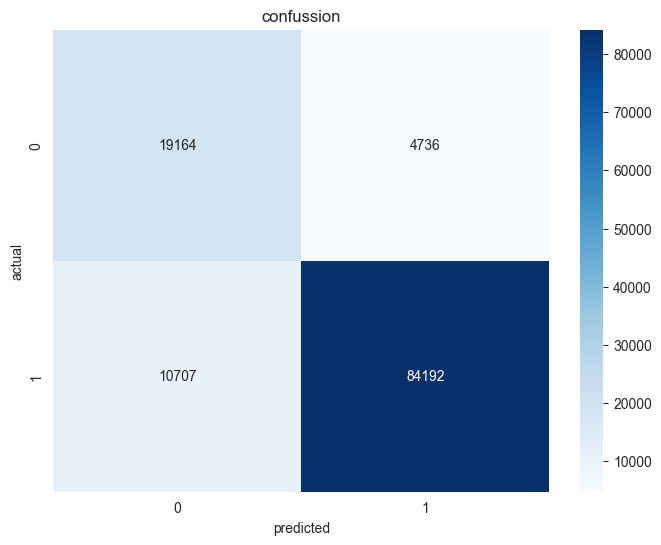

In [38]:
# 计算混淆矩阵
cm = confusion_matrix(valid[TARGET], (valid_fsp > 0.5).astype(int))
print("混淆矩阵:")
print(cm)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('confussion')

## New Feature

In [69]:
# Add a new feature INTERTAR that contains quadratic information and is processed with TarEncoding
INTERTAR = []

intertar = TargetEncoder(cols_to_encode=INTER, aggs=['mean', 'count'], drop_original=True)
def generate_inter_target_feature(df, *df_other):
    other = list(df_other)

    # astype category to str, later change them back
    cate_cols = [i for i, x in df.dtypes.items() if x == 'category']
    for col in cate_cols:
        df[col] = df[col].astype(str)
        for i in range(len(other)):
            other[i][col] = other[i][col].astype(str)

    df_tar = intertar.fit_transform(df[INTER], df[TARGET])
    df = df.join(df_tar)
    for i in range(len(other)):
        other[i] = other[i].join(intertar.transform(other[i][INTER]))
    INTERTAR.extend(df_tar.columns)

    for col in cate_cols:
        df[col] = df[col].astype('category')
        for i in range(len(other)):
            other[i][col] = other[i][col].astype('category')

    return df, *other

train, test, valid = generate_inter_target_feature(train, test, valid)
print(f'{len(INTERTAR)} Inter Target features created.')

72 Target features created.


In [81]:
# Add a new feature ROUNDAR that contains round information and is processed with TarEncoding
ROUNDTAR = []

roundtar = TargetEncoder(cols_to_encode=ROUND, aggs=['mean', 'count'], drop_original=True)
def generate_round_target_feature(df, *df_other):
    other = list(df_other)

    df_tar = roundtar.fit_transform(df[ROUND], df[TARGET])
    df = df.join(df_tar)
    for i in range(len(other)):
        other[i] = other[i].join(roundtar.transform(other[i][ROUND]))
    ROUNDTAR.extend(df_tar.columns)

    return df, *other

train, test, valid = generate_round_target_feature(train, test, valid)
print(f'{len(ROUNDTAR)} Round Target features created.')

12 Target features created.


## RESIDUAL MODEL FOR LABEL

In [84]:
train_fsp = pd.read_csv(os.path.join(DIR, 'sub\\scale_weight\\train_fsp.csv'), index_col='id')
resid = train[TARGET] - train_fsp[TARGET]

In [91]:
cv = 5
resid_feas_select = []

In [92]:
resid_feas_select.append(('RAW', xgg_feature_test(train[COL], resid, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### FOLD : 1 ###
#########################

[0]	train-rmse:0.28720	valid-rmse:0.27816
[220]	train-rmse:0.25700	valid-rmse:0.27286
FOLD 1 RMSE: 0.07445

#########################
### FOLD : 2 ###
#########################

[0]	train-rmse:0.28739	valid-rmse:0.27668
[207]	train-rmse:0.25755	valid-rmse:0.27222
FOLD 2 RMSE: 0.07411

#########################
### FOLD : 3 ###
#########################

[0]	train-rmse:0.28718	valid-rmse:0.27770
[208]	train-rmse:0.25736	valid-rmse:0.27350
FOLD 3 RMSE: 0.07480

#########################
### FOLD : 4 ###
#########################

[0]	train-rmse:0.28720	valid-rmse:0.27730
[206]	train-rmse:0.25762	valid-rmse:0.27298
FOLD 4 RMSE: 0.07452

#########################
### FOLD : 5 ###
#########################

[0]	train-rmse:0.27677	valid-rmse:0.32538
[250]	train-rmse:0.24720	valid-rmse:0.30774
FOLD 5 RMSE: 0.09471

MEAN RMSE: 0.07852


In [93]:
resid_feas_select.append(('INTERTAR', xgg_feature_test(train[COL+INTERTAR], resid, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### FOLD : 1 ###
#########################

[0]	train-rmse:0.28466	valid-rmse:0.27772
[212]	train-rmse:0.23815	valid-rmse:0.27243
FOLD 1 RMSE: 0.07422

#########################
### FOLD : 2 ###
#########################

[0]	train-rmse:0.28489	valid-rmse:0.27662
[203]	train-rmse:0.23882	valid-rmse:0.28215
FOLD 2 RMSE: 0.07961

#########################
### FOLD : 3 ###
#########################

[0]	train-rmse:0.28414	valid-rmse:0.27683
[207]	train-rmse:0.23843	valid-rmse:0.27362
FOLD 3 RMSE: 0.07489

#########################
### FOLD : 4 ###
#########################

[0]	train-rmse:0.28441	valid-rmse:0.27719
[208]	train-rmse:0.23753	valid-rmse:0.27662
FOLD 4 RMSE: 0.07652

#########################
### FOLD : 5 ###
#########################

[0]	train-rmse:0.27588	valid-rmse:0.32419
[220]	train-rmse:0.23574	valid-rmse:0.30560
FOLD 5 RMSE: 0.09339

MEAN RMSE: 0.07973


In [94]:
resid_feas_select.append(('ROUNDTAR', xgg_feature_test(train[COL+ROUNDTAR], resid, cv=cv, eval_metric='rmse', objective='reg:squarederror')))


#########################
### FOLD : 1 ###
#########################

[0]	train-rmse:0.28719	valid-rmse:0.27814
[207]	train-rmse:0.24954	valid-rmse:0.27396
FOLD 1 RMSE: 0.07505

#########################
### FOLD : 2 ###
#########################

[0]	train-rmse:0.28737	valid-rmse:0.27664
[205]	train-rmse:0.24985	valid-rmse:0.27358
FOLD 2 RMSE: 0.07486

#########################
### FOLD : 3 ###
#########################

[0]	train-rmse:0.28717	valid-rmse:0.27773
[206]	train-rmse:0.24969	valid-rmse:0.27432
FOLD 3 RMSE: 0.07526

#########################
### FOLD : 4 ###
#########################

[0]	train-rmse:0.28719	valid-rmse:0.27731
[207]	train-rmse:0.24985	valid-rmse:0.27422
FOLD 4 RMSE: 0.07520

#########################
### FOLD : 5 ###
#########################

[0]	train-rmse:0.27673	valid-rmse:0.32538
[242]	train-rmse:0.24189	valid-rmse:0.30839
FOLD 5 RMSE: 0.09510

MEAN RMSE: 0.07909


In [95]:
resid_feas_select.sort(key=lambda x: x[1][0])
print('#'*25)
print('### feature selection rank ###')
print(f"{'#'*25}\n")
for i, (fea, (rmse,)) in enumerate(resid_feas_select):
    print(f'{i+1} {fea} RMSE: {rmse:.5f}')

#########################
### feature selection rank ###
#########################

1 RAW RMSE: 0.07852
2 ROUNDTAR RMSE: 0.07909
3 INTERTAR RMSE: 0.07973


In [97]:
resid_label_param = tune_xgb_with_optuna(train[ROUNDTAR+INTERTAR], train[TARGET], train_fsp[TARGET], seed=SEED)

[I 2025-11-18 20:46:26,749] A new study created in memory with name: xgb_cv_tuning


Starting Optuna tuning with 5-fold CV on residuals...


Best trial: 0. Best value: 0.915554:  10%|█         | 1/10 [01:38<14:44, 98.23s/it, 98.23/900 seconds]

Trial 0: CV AUC = 0.91555
[I 2025-11-18 20:48:04,979] Trial 0 finished with value: 0.9155541412441831 and parameters: {'max_depth': 4, 'min_child_weight': 14.640440384145329, 'subsample': 0.8390629493581139, 'colsample_bytree': 0.9355465334087385, 'reg_alpha': 0.869802678691683, 'reg_lambda': 0.503625192133767, 'gamma': 2.1217469508351487, 'max_leaves': 16}. Best is trial 0 with value: 0.9155541412441831.


Best trial: 1. Best value: 0.916219:  20%|██        | 2/10 [03:09<12:31, 93.91s/it, 189.11/900 seconds]

Trial 1: CV AUC = 0.91622
[I 2025-11-18 20:49:35,859] Trial 1 finished with value: 0.916219014566271 and parameters: {'max_depth': 3, 'min_child_weight': 2.8706919797249286, 'subsample': 0.9829820181139526, 'colsample_bytree': 0.9278856126483065, 'reg_alpha': 0.04985123141864478, 'reg_lambda': 0.6964733793561483, 'gamma': 4.154419031797907, 'max_leaves': 19}. Best is trial 1 with value: 0.916219014566271.


Best trial: 2. Best value: 0.916528:  30%|███       | 3/10 [04:51<11:25, 97.86s/it, 291.67/900 seconds]

Trial 2: CV AUC = 0.91653
[I 2025-11-18 20:51:18,425] Trial 2 finished with value: 0.9165277081731812 and parameters: {'max_depth': 9, 'min_child_weight': 3.244500981903763, 'subsample': 0.7456542703581011, 'colsample_bytree': 0.6501046947320065, 'reg_alpha': 0.8300527907194137, 'reg_lambda': 3.3934412354657817, 'gamma': 1.7556783894833439, 'max_leaves': 12}. Best is trial 2 with value: 0.9165277081731812.


Best trial: 2. Best value: 0.916528:  40%|████      | 4/10 [06:43<10:20, 103.41s/it, 403.60/900 seconds]

Trial 3: CV AUC = 0.91422
[I 2025-11-18 20:53:10,347] Trial 3 finished with value: 0.9142184273342313 and parameters: {'max_depth': 6, 'min_child_weight': 1.6860938107830779, 'subsample': 0.7047531060417596, 'colsample_bytree': 0.8182808889857593, 'reg_alpha': 1.7682365369440394, 'reg_lambda': 1.9971705056321487, 'gamma': 0.6876782115183122, 'max_leaves': 6}. Best is trial 2 with value: 0.9165277081731812.


Best trial: 2. Best value: 0.916528:  50%|█████     | 5/10 [08:24<08:32, 102.55s/it, 504.63/900 seconds]

Trial 4: CV AUC = 0.91606
[I 2025-11-18 20:54:51,387] Trial 4 finished with value: 0.9160592176133442 and parameters: {'max_depth': 4, 'min_child_weight': 14.846734690566743, 'subsample': 0.9832950235790856, 'colsample_bytree': 0.8221769290003612, 'reg_alpha': 0.0257069027591299, 'reg_lambda': 1.6003363393557912, 'gamma': 1.3330407921870524, 'max_leaves': 18}. Best is trial 2 with value: 0.9165277081731812.


Best trial: 2. Best value: 0.916528:  60%|██████    | 6/10 [10:02<06:44, 101.05s/it, 602.77/900 seconds]

Trial 5: CV AUC = 0.91601
[I 2025-11-18 20:56:29,521] Trial 5 finished with value: 0.9160054475373858 and parameters: {'max_depth': 6, 'min_child_weight': 2.7965073247861545, 'subsample': 0.8047313624884556, 'colsample_bytree': 0.9736730862625642, 'reg_alpha': 1.1895492868639959, 'reg_lambda': 1.0564705168788946, 'gamma': 3.0151697860212376, 'max_leaves': 5}. Best is trial 2 with value: 0.9165277081731812.


Best trial: 2. Best value: 0.916528:  70%|███████   | 7/10 [11:41<05:00, 100.23s/it, 701.29/900 seconds]

Trial 6: CV AUC = 0.91610
[I 2025-11-18 20:58:08,046] Trial 6 finished with value: 0.9160987525907073 and parameters: {'max_depth': 4, 'min_child_weight': 4.605835147224476, 'subsample': 0.7925001060952482, 'colsample_bytree': 0.7736793380386346, 'reg_alpha': 0.7644622774141154, 'reg_lambda': 3.611413849712082, 'gamma': 1.8549261496201974, 'max_leaves': 23}. Best is trial 2 with value: 0.9165277081731812.


Best trial: 2. Best value: 0.916528:  80%|████████  | 8/10 [13:14<03:16, 98.05s/it, 794.70/900 seconds] 

Trial 7: CV AUC = 0.91600
[I 2025-11-18 20:59:41,448] Trial 7 finished with value: 0.9159984314346896 and parameters: {'max_depth': 4, 'min_child_weight': 4.8067014149651, 'subsample': 0.636307943651376, 'colsample_bytree': 0.7657930485378721, 'reg_alpha': 0.6896339288129827, 'reg_lambda': 0.8201081033231833, 'gamma': 2.8193658905340016, 'max_leaves': 18}. Best is trial 2 with value: 0.9165277081731812.


Best trial: 2. Best value: 0.916528:  90%|█████████ | 9/10 [15:20<01:42, 102.26s/it, 920.37/900 seconds]

Trial 8: CV AUC = 0.91525
[I 2025-11-18 21:01:47,120] Trial 8 finished with value: 0.9152541231785539 and parameters: {'max_depth': 6, 'min_child_weight': 2.270876400866735, 'subsample': 0.8602912877642734, 'colsample_bytree': 0.9772548940776693, 'reg_alpha': 1.8486234627416556, 'reg_lambda': 3.8765750896890276, 'gamma': 0.8792190735273903, 'max_leaves': 27}. Best is trial 2 with value: 0.9165277081731812.

Best trial summary:
  • Best AUC: 0.916528
  • Best parameters: {'max_depth': 9, 'min_child_weight': 3.244500981903763, 'subsample': 0.7456542703581011, 'colsample_bytree': 0.6501046947320065, 'reg_alpha': 0.8300527907194137, 'reg_lambda': 3.3934412354657817, 'gamma': 1.7556783894833439, 'max_leaves': 12}


In [98]:
# Save the residual model params
with open(os.path.join(DIR, 'model\\scale_weight\\resid_label_param.json'), 'w') as f:
    json.dump(resid_label_param[0], f, indent=4)

In [102]:
# read the base model's predictions
pre_prev_train = pd.read_csv(os.path.join(DIR, 'sub\\scale_weight\\train_fsp.csv'), index_col='id')
pre_prev_valid = pd.read_csv(os.path.join(DIR, 'sub\\scale_weight\\valid_fsp.csv'), index_col='id')
pre_prev_test = pd.read_csv(os.path.join(DIR, 'sub\\scale_weight\\test_fsp.csv'), index_col='id')
resid = train[TARGET] - pre_prev_train[TARGET]

with open(os.path.join(DIR, 'model\\scale_weight\\resid_label_param.json'), 'r') as f:
    param = json.load(f)
param.update({
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",
    "device": "cuda",
    'booster': 'gbtree',
    "learning_rate": 0.005,
    'seed': SEED,
})

cv=5
used_feas = INTERTAR+ROUNDTAR
kf = KFold(n_splits=cv, shuffle=True, random_state=SEED)

train_ssp = np.zeros(train.shape[0])
valid_ssp = np.zeros(valid.shape[0])
test_ssp = np.zeros(test.shape[0]) # contain the predictions of test data by base model using cv
auc_res = []
acc_res = []
f1_res = []
for fold, (train_idx, valid_idx) in enumerate(kf.split(train)):
    X_train, X_valid = train[used_feas].iloc[train_idx], train[used_feas].iloc[valid_idx]
    y_train, y_valid = resid.iloc[train_idx], resid.iloc[valid_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
    dtest = xgb.DMatrix(test[used_feas], enable_categorical=True)
    DVALID = xgb.DMatrix(valid[used_feas], enable_categorical=True)

    # Train base model
    model = xgb.train(
        params=param,
        dtrain=dtrain,
        num_boost_round=3000,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        early_stopping_rounds=10000,
        verbose_eval=False,
    )

    # Predict probs
    valid_preds = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
    valid_preds_proba = np.clip(valid_preds + pre_prev_train.iloc[valid_idx].values.flatten(), 0, 1)
    train_ssp[valid_idx] = valid_preds_proba
    test_ssp += model.predict(dtest, iteration_range=(0, model.best_iteration + 1))
    valid_ssp += model.predict(DVALID, iteration_range=(0, model.best_iteration + 1))
    # auc
    y_true = train[TARGET].iloc[valid_idx]
    auc = roc_auc_score(y_true, valid_preds_proba)
    auc_res.append(auc)
    # acc
    y_pred = (valid_preds_proba > 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred)
    acc_res.append(acc)
    # f1
    f1 = f1_score(y_true, y_pred)
    f1_res.append(f1)
    print(f'{fold+1} auc = {auc:.5f} acc = {acc:.5f} f1 = {f1:.5f}')


test_ssp = np.clip(test_ssp/cv + pre_prev_test.values.flatten(), 0, 1)
valid_ssp = np.clip(valid_ssp/cv + pre_prev_valid.values.flatten(), 0, 1)
# Save test data predictions
pd.DataFrame(data={'id': test.index, TARGET: test_ssp}).to_csv(os.path.join(DIR, 'sub\\scale_weight\\test_ssp.csv'),index=False,header=True)
pd.DataFrame(data={'id': train.index, TARGET: train_ssp}).to_csv(os.path.join(DIR, 'sub\\scale_weight\\train_ssp.csv'),index=False,header=True)
pd.DataFrame(data={'id': valid.index, TARGET: valid_ssp}).to_csv(os.path.join(DIR, 'sub\\scale_weight\\valid_ssp.csv'),index=False,header=True)

print(f'BASE MODEL AUC = {np.mean(auc_res):.5f} ACC = {np.mean(acc_res):.5f} F1 = {np.mean(f1_res):.5f}.')
print(f'BASE MODEL ON VALID DATA AUC = {roc_auc_score(valid[TARGET], valid_ssp)} ACC = {accuracy_score(valid[TARGET], (valid_ssp>0.5).astype(int))} F1 = {f1_score(valid[TARGET], (valid_ssp>0.5).astype(int))}')

1 auc = 0.91557 acc = 0.90825 f1 = 0.94427
2 auc = 0.91792 acc = 0.90782 f1 = 0.94387
3 auc = 0.91741 acc = 0.90792 f1 = 0.94400
4 auc = 0.91518 acc = 0.90920 f1 = 0.94491
5 auc = 0.91711 acc = 0.89553 f1 = 0.93489
BASE MODEL AUC = 0.91664 ACC = 0.90574 F1 = 0.94239.
BASE MODEL ON VALID DATA AUC = 0.9175519463304325 ACC = 0.9078443421240919 F1 = 0.9440618038382146


混淆矩阵:
[[15467  8433]
 [ 2515 92384]]


Text(0.5, 1.0, 'confussion')

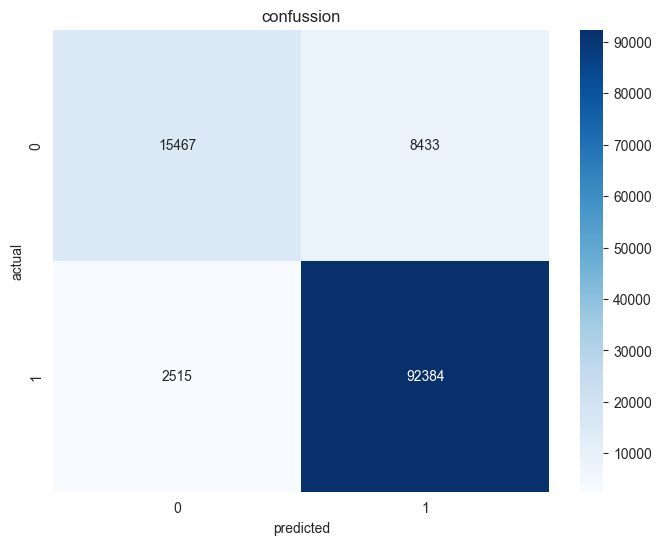

In [103]:
# 计算混淆矩阵
cm = confusion_matrix(valid[TARGET], (valid_ssp > 0.5).astype(int))
print("混淆矩阵:")
print(cm)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('confussion')

## RESIDUAL MODEL FOR FEATURE

In [14]:
pre_prev_train = pd.read_csv(os.path.join(DIR, 'sub\\scale_weight\\train_fsp.csv'), index_col='id')
pre_prev_valid = pd.read_csv(os.path.join(DIR, 'sub\\scale_weight\\valid_fsp.csv'), index_col='id')
pre_prev_test = pd.read_csv(os.path.join(DIR, 'sub\\scale_weight\\test_fsp.csv'), index_col='id')

In [71]:
# Add the logits predicted as a feature
def inv_sigmoid(X):
    return -np.log(1/X - 1)

RESID = ['RESID']

train['RESID'] = inv_sigmoid(pre_prev_train)
valid['RESID'] = inv_sigmoid(pre_prev_valid)
test['RESID'] = inv_sigmoid(pre_prev_test)

In [73]:
resid_feature_param = tune_xgb_with_optuna(train[RESID+FREQ+TAR+ROUNDTAR+INTERTAR], train[TARGET], seed=SEED)

[I 2025-11-17 22:43:15,885] A new study created in memory with name: xgb_cv_tuning


Starting Optuna tuning with 5-fold CV on residuals...


Best trial: 0. Best value: 0.925334:  10%|█         | 1/10 [02:05<18:52, 125.82s/it, 125.82/900 seconds]

Trial 0: CV AUC = 0.92533
[I 2025-11-17 22:45:21,702] Trial 0 finished with value: 0.9253341235327929 and parameters: {'max_depth': 9, 'min_child_weight': 7.194029771913119, 'subsample': 0.6200247715443793, 'colsample_bytree': 0.6716296237477886, 'reg_alpha': 0.7736705186651041, 'reg_lambda': 0.8825586867705255, 'gamma': 0.9300815906562265, 'max_leaves': 9, 'learning_rate': 0.016135929581529197}. Best is trial 0 with value: 0.9253341235327929.


Best trial: 0. Best value: 0.925334:  20%|██        | 2/10 [04:12<16:51, 126.42s/it, 252.66/900 seconds]

Trial 1: CV AUC = 0.92524
[I 2025-11-17 22:47:28,543] Trial 1 finished with value: 0.9252434915046633 and parameters: {'max_depth': 8, 'min_child_weight': 7.458689600716569, 'subsample': 0.6519149818946511, 'colsample_bytree': 0.6586606922201832, 'reg_alpha': 1.4259677877417638, 'reg_lambda': 4.864543627851508, 'gamma': 0.4199484284939481, 'max_leaves': 9, 'learning_rate': 0.14514217408321678}. Best is trial 0 with value: 0.9253341235327929.


Best trial: 0. Best value: 0.925334:  30%|███       | 3/10 [06:18<14:41, 125.96s/it, 378.08/900 seconds]

Trial 2: CV AUC = 0.92523
[I 2025-11-17 22:49:33,966] Trial 2 finished with value: 0.9252285702887889 and parameters: {'max_depth': 8, 'min_child_weight': 14.627824737660308, 'subsample': 0.7258785618270559, 'colsample_bytree': 0.8245707714063988, 'reg_alpha': 1.8113728015039907, 'reg_lambda': 1.5600152426769862, 'gamma': 1.982407766527321, 'max_leaves': 13, 'learning_rate': 0.042969413164294604}. Best is trial 0 with value: 0.9253341235327929.


Best trial: 0. Best value: 0.925334:  40%|████      | 4/10 [07:52<11:20, 113.36s/it, 472.11/900 seconds]

Trial 3: CV AUC = 0.92516
[I 2025-11-17 22:51:07,992] Trial 3 finished with value: 0.9251550418357948 and parameters: {'max_depth': 5, 'min_child_weight': 7.855714319970533, 'subsample': 0.8995692521384828, 'colsample_bytree': 0.7282917845889684, 'reg_alpha': 1.8049202427247464, 'reg_lambda': 0.6906508965750134, 'gamma': 2.842997077617478, 'max_leaves': 22, 'learning_rate': 0.1436689453663814}. Best is trial 0 with value: 0.9253341235327929.


Best trial: 0. Best value: 0.925334:  50%|█████     | 5/10 [09:53<09:41, 116.22s/it, 593.41/900 seconds]

Trial 4: CV AUC = 0.92505
[I 2025-11-17 22:53:09,296] Trial 4 finished with value: 0.925051137465694 and parameters: {'max_depth': 6, 'min_child_weight': 13.072020745523796, 'subsample': 0.860307050961622, 'colsample_bytree': 0.9756671898470297, 'reg_alpha': 1.0306934966489674, 'reg_lambda': 2.797795146586489, 'gamma': 1.638109079619963, 'max_leaves': 23, 'learning_rate': 0.07035487094825486}. Best is trial 0 with value: 0.9253341235327929.


Best trial: 0. Best value: 0.925334:  60%|██████    | 6/10 [11:28<07:15, 108.97s/it, 688.32/900 seconds]

Trial 5: CV AUC = 0.92526
[I 2025-11-17 22:54:44,198] Trial 5 finished with value: 0.9252621280366187 and parameters: {'max_depth': 9, 'min_child_weight': 14.767655531677073, 'subsample': 0.7991058440704492, 'colsample_bytree': 0.8759437559796772, 'reg_alpha': 0.41512241844878583, 'reg_lambda': 2.8604943355727595, 'gamma': 4.65259158163625, 'max_leaves': 6, 'learning_rate': 0.09581391618021601}. Best is trial 0 with value: 0.9253341235327929.


Best trial: 0. Best value: 0.925334:  70%|███████   | 7/10 [13:45<05:55, 118.34s/it, 825.94/900 seconds]

Trial 6: CV AUC = 0.92522
[I 2025-11-17 22:57:01,831] Trial 6 finished with value: 0.9252240921621796 and parameters: {'max_depth': 8, 'min_child_weight': 7.851815445468441, 'subsample': 0.6314086493356351, 'colsample_bytree': 0.7205633982808936, 'reg_alpha': 0.04782269039665077, 'reg_lambda': 1.3491988835303572, 'gamma': 2.6471952824998985, 'max_leaves': 24, 'learning_rate': 0.04004369350450511}. Best is trial 0 with value: 0.9253341235327929.


Best trial: 0. Best value: 0.925334:  80%|████████  | 8/10 [15:40<03:55, 117.53s/it, 940.26/900 seconds]

Trial 7: CV AUC = 0.92528
[I 2025-11-17 22:58:56,145] Trial 7 finished with value: 0.9252839182429643 and parameters: {'max_depth': 3, 'min_child_weight': 5.296066926878064, 'subsample': 0.7249047517909447, 'colsample_bytree': 0.8612010364622107, 'reg_alpha': 0.9531899878290935, 'reg_lambda': 0.7443889536453914, 'gamma': 1.2281196096902298, 'max_leaves': 23, 'learning_rate': 0.04699334381096737}. Best is trial 0 with value: 0.9253341235327929.

Best trial summary:
  • Best AUC: 0.925334
  • Best parameters: {'max_depth': 9, 'min_child_weight': 7.194029771913119, 'subsample': 0.6200247715443793, 'colsample_bytree': 0.6716296237477886, 'reg_alpha': 0.7736705186651041, 'reg_lambda': 0.8825586867705255, 'gamma': 0.9300815906562265, 'max_leaves': 9, 'learning_rate': 0.016135929581529197}


In [74]:
# Save the residual model params
with open(os.path.join(DIR, 'model\\scale_weight\\resid_feature_param.json'), 'w') as f:
    json.dump(resid_feature_param[0], f, indent=4)

In [83]:
with open(os.path.join(DIR, 'model\\scale_weight\\resid_feature_param.json'), 'r') as f:
    param = json.load(f)
param.update({
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",
    "device": "cuda",
    'booster': 'gbtree',
    'seed': SEED,
    'scale_pos_weight': nvp,
})

cv=5
used_feas = INTERTAR+RESID+TAR+FREQ+ROUNDTAR
kf = KFold(n_splits=cv, shuffle=True, random_state=SEED)

train_tsp = np.zeros(train.shape[0])
valid_tsp = np.zeros(valid.shape[0])
test_tsp = np.zeros(test.shape[0]) # contain the predictions of test data by base model using cv
auc_res = []
acc_res = []
f1_res = []
for fold, (train_idx, valid_idx) in enumerate(kf.split(train)):
    X_train, X_valid = train[used_feas].iloc[train_idx], train[used_feas].iloc[valid_idx]
    y_train, y_valid = train[TARGET].iloc[train_idx], train[TARGET].iloc[valid_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
    dtest = xgb.DMatrix(test[used_feas], enable_categorical=True)
    DVALID = xgb.DMatrix(valid[used_feas], enable_categorical=True)

    # Train base model
    model = xgb.train(
        params=param,
        dtrain=dtrain,
        num_boost_round=10000,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        early_stopping_rounds=100,
        verbose_eval=False,
    )

    # Predict probs
    valid_preds = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
    train_tsp[valid_idx] = valid_preds
    test_tsp += model.predict(dtest, iteration_range=(0, model.best_iteration + 1))
    valid_tsp += model.predict(DVALID, iteration_range=(0, model.best_iteration + 1))
    # auc
    auc = roc_auc_score(y_valid, valid_preds)
    auc_res.append(auc)
    # acc
    y_pred = (valid_preds > 0.5).astype(int)
    acc = accuracy_score(y_valid, y_pred)
    acc_res.append(acc)
    # f1
    f1 = f1_score(y_valid, y_pred)
    f1_res.append(f1)
    print(f'{fold+1} auc = {auc:.5f} acc = {acc:.5f} f1 = {f1:.5f}')


test_tsp /= cv
valid_tsp /= cv
# Save test data predictions
pd.DataFrame(data={'id': train.index, TARGET: train_tsp}).to_csv(os.path.join(DIR, 'sub\\scale_weight\\train_tsp.csv'),index=False,header=True)
pd.DataFrame(data={'id': test.index, TARGET: test_tsp}).to_csv(os.path.join(DIR, 'sub\\scale_weight\\test_tsp.csv'),index=False,header=True)
pd.DataFrame(data={'id': valid.index, TARGET: valid_tsp}).to_csv(os.path.join(DIR, 'sub\\scale_weight\\valid_tsp.csv'),index=False,header=True)
# np.save(os.path.join(DIR, 'data\\test_fsp.npy'), test_fsp)
# np.save(os.path.join(DIR, 'data\\train_fsp.npy'), train_fsp)

print(f'BASE MODEL AUC = {np.mean(auc_res):.5f} ACC = {np.mean(acc_res):.5f} F1 = {np.mean(f1_res):.5f}.')
print(f'BASE MODEL ON VALID DATA AUC = {roc_auc_score(valid[TARGET], valid_tsp)} ACC = {accuracy_score(valid[TARGET], (valid_tsp>0.5).astype(int))} F1 = {f1_score(valid[TARGET], (valid_tsp>0.5).astype(int))}')

1 auc = 0.92691 acc = 0.87214 f1 = 0.91755
2 auc = 0.92794 acc = 0.87712 f1 = 0.92105
3 auc = 0.92657 acc = 0.87531 f1 = 0.91980
4 auc = 0.92632 acc = 0.89612 f1 = 0.93486
5 auc = 0.92421 acc = 0.80234 f1 = 0.86400
BASE MODEL AUC = 0.92639 ACC = 0.86461 F1 = 0.91145.
BASE MODEL ON VALID DATA AUC = 0.9264776066040878 ACC = 0.8736942230153453 F1 = 0.9185869229058039


混淆矩阵:
[[18976  4924]
 [ 9911 84988]]


Text(0.5, 1.0, 'confussion')

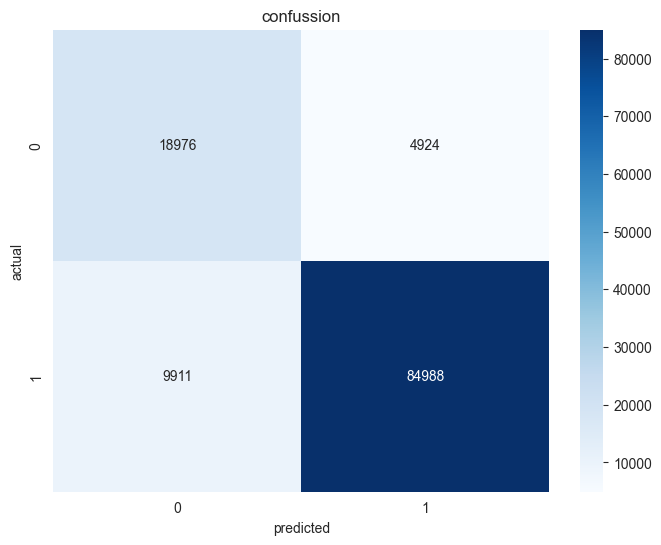

In [80]:
# 计算混淆矩阵
cm = confusion_matrix(valid[TARGET], (valid_tsp > 0.5).astype(int))
print("混淆矩阵:")
print(cm)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('confussion')